## Importing necessary packages

In [2]:
import email
import email.policy
import re
import nltk
nltk.download('words')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing (10 points)

### Extracting the stopwords

In [3]:
with open('../problem_set/stop_words.txt', 'r') as stopword_file:
    stopwords = stopword_file.readlines()
stopwords = [x.strip() for x in stopwords]

### Function to clean the email body

In [4]:
words = set(nltk.corpus.words.words())

def clean_email_body(body, stopwords):
    # split body into words
    tokens = word_tokenize(body)
    
    #convert to lowercase
    tokens = [w.lower() for w in tokens]
    
    #removes all tokens that are not alphabetic
    email_words = [word for word in tokens if word.isalpha()]
    
    # uncomment code below to retain numbers
    # email_words = [word for word in tokens if word.isalnum()]
    
    # removes all nonsensical words
    email_words = [w for w in email_words if w.lower() in words]
    
    #filter out stop words
    email_words = [w for w in email_words if not w in stopwords]
    
    clean_body = ' '.join(email_words)
    
    return clean_body

### Function to extract the email body from the email file

In [5]:
def get_email_body(path):
    with open(path, 'rb') as file:
        b = email.message_from_binary_file(file)
    if b.is_multipart():
        for part in b.walk():
            if part.get_content_type() == 'text/plain':
                main_part = part.get_payload()
                main_part = clean_email_body(main_part, stopwords)
                return main_part
                break
    else:
        main_part = b.get_payload()
        main_part = clean_email_body(main_part, stopwords)
        return main_part

### Starts pre-processing the email files

1) The email body is extracted from the email file. 2) The email body is cleaned.

In [6]:
# NOTE: 'catdir' means category and directory
# Reading every line in the 'labels' file to get the catdir of each email file
label_file = open('../problem_set/labels', 'r')
with label_file as file:
    # Returns a list where the elements are the catdir of each email file
    # Example: ['ham ../data/000/000', 'spam ../data/000/001', ...]
    file_catdirs = file.read().splitlines()

train_set_list = []
train_set_list_ham = []
train_set_list_spam = []
test_set_list = []

# Starts processing the files
for file_catdir in file_catdirs:
    
    # Splits the catdir of the email file to easily retrieve the category and folders
    # Example: 'ham ../data/000/000' -> ['ham ..', 'data', '000', '000']
    file_details = file_catdir.split('/')
    
    # Final directory
    # Appends the directory of the email file to the parent directory; do this to avoid error
    file_dir = "../problem_set" + file_catdir[file_catdir.find('/data'):]
    # print(file_dir)
    
    # NOTE: 'bodcat' means body and category
    email_bodcat = []
    
    # Extract the email body and category to be added as a row in the train/test set
    email_bod = get_email_body(file_dir)
    
    if not(email_bod is None):
        email_bodcat.append(email_bod)
        email_cat = file_details[0]
        if email_cat[0] == 'h':
            email_bodcat.append('ham')
        else:
            email_bodcat.append('spam')
    else:
        continue
    
    # Divides the email files into train and test set based on the instructions
    # Folders 0-70 are train set, 71-127 are test set
    if (int(file_details[2]) <= 70):
        train_set_list.append(email_bodcat)
        
        # further divides the train set into train set for ham and spam
        if (file_details[0].startswith("ham")):
            train_set_list_ham.append(email_bodcat)
        else:
            train_set_list_spam.append(email_bodcat)
    else:
        test_set_list.append(email_bodcat)

In [7]:
# # uncomment this so that train set will show all ham emails first, then spam emails second
# train_set_list = train_set_list_ham + train_set_list_spam

#### Training set

In [8]:
train_df = pd.DataFrame(train_set_list, columns=['Message', 'Category'])
train_df

,Message,Category
0,list ago running set archive server official l...,ham
1,luxury buy frank muller omega tag full gold me...,spam
2,academic prestigious knowledge experience lack...,spam
3,verify subscription list charter day order chu...,ham
4,luscious continued tonsillitis,spam
...,...,...
20800,,spam
20801,special offer adobe video collection adobe pre...,spam
20802,public head meta title style body color color ...,spam
20803,mounted infrared demodulator direction mount m...,ham


#### Training set for ham

In [9]:
train_df_ham = pd.DataFrame(train_set_list_ham, columns=['Message', 'Category'])
train_df_ham

,Message,Category
0,list ago running set archive server official l...,ham
1,verify subscription list charter day order chu...,ham
2,quiet quiet well straw poll running,ham
3,working departed totally bell configuration ru...,ham
4,mass list influx bit people list person list a...,ham
...,...,...
7518,equation generate prime equation theorem prime...,ham
7519,equation generate prime equation theorem prime...,ham
7520,dear guidance generating item experiment learn...,ham
7521,built works great infrared remote fine port po...,ham


#### Training set for spam

In [10]:
train_df_spam = pd.DataFrame(train_set_list_spam, columns=['Message', 'Category'])
train_df_spam

,Message,Category
0,luxury buy frank muller omega tag full gold me...,spam
1,academic prestigious knowledge experience lack...,spam
2,luscious continued tonsillitis,spam
3,today body diet will deep distant culture sout...,spam
4,oil sector going crazy weekly gift thing going...,spam
...,...,...
13277,,spam
13278,,spam
13279,special offer adobe video collection adobe pre...,spam
13280,public head meta title style body color color ...,spam


#### Testing set

In [11]:
test_df = pd.DataFrame(test_set_list, columns=['Message', 'Category'])
test_df

,Message,Category
0,hesitantly derive perverse satisfaction midwif...,spam
1,perform experiment display will remain screen ...,ham
2,best offer month time,spam
3,de ar matter ow real st te en simply ower mont...,spam
4,special offer adobe video collection adobe pre...,spam
...,...,...
16023,great news ted price climb well marketing camp...,spam
16024,oil sector going crazy weekly gift thing going...,spam
16025,suffering pain depression heartburn help colle...,spam
16026,prosperous future money earning power respect ...,spam


### Extracting the 10000 most common words on the dataset

#### Function to convert list of tuples to dictionary

In [12]:
def convert_to_dict(tuples, dictionary):
    dictionary = dict(tuples)
    return dictionary

#### Most common words in the training set that have occured 150 times or more.

In [16]:
train_words_freq = {}

train_df.fillna("", inplace=True)
words_freq_tuples = Counter(" ".join(train_df.Message).lower().split())

train_words_freq = convert_to_dict(words_freq_tuples, train_words_freq)

words = list(train_words_freq.keys())
for word in words:
    if train_words_freq[word] < 150:
        del train_words_freq[word]

print("New length: " + str(len(train_words_freq)))
train_words_freq

New length: 1232


{'list': 3961,
 'ago': 661,
 'running': 953,
 'set': 1572,
 'archive': 184,
 'server': 558,
 'official': 188,
 'message': 3618,
 'moment': 189,
 'joe': 150,
 'people': 1785,
 'desire': 245,
 'discussion': 602,
 'assume': 207,
 'will': 11322,
 'provided': 299,
 'operate': 199,
 'going': 1185,
 'limit': 172,
 'sort': 311,
 'net': 226,
 'well': 2405,
 'hope': 841,
 'help': 3805,
 'problem': 2359,
 'resource': 344,
 'policy': 217,
 'subject': 3580,
 'appropriate': 280,
 'call': 1740,
 'simple': 635,
 'follow': 308,
 'teaching': 247,
 'thinking': 273,
 'subscribe': 1499,
 'interest': 595,
 'interesting': 466,
 'setting': 321,
 'language': 519,
 'magazine': 213,
 'days': 1567,
 'material': 332,
 'intend': 227,
 'post': 1138,
 'higher': 391,
 'quality': 526,
 'send': 3685,
 'luxury': 155,
 'buy': 728,
 'frank': 389,
 'muller': 199,
 'omega': 201,
 'tag': 248,
 'full': 1142,
 'gold': 3896,
 'men': 618,
 'fast': 809,
 'delivery': 421,
 'shipping': 635,
 'visit': 677,
 'shop': 207,
 'academic': 

#### Most common words in the testing set

In [17]:
test_words_freq = {}

test_df.fillna("", inplace=True)
test_words_freq_tuples = Counter(" ".join(test_df.Message).lower().split()).most_common(10000)

test_words_freq = convert_to_dict(test_words_freq_tuples, test_words_freq)
test_words_freq

{'font': 13696,
 'will': 13622,
 'vulnerable': 8702,
 'received': 8084,
 'subject': 6252,
 'list': 5705,
 'file': 5563,
 'time': 5533,
 'company': 4904,
 'message': 4876,
 'number': 4247,
 'quot': 4067,
 'wrote': 4040,
 'system': 3835,
 'mail': 3831,
 'price': 3739,
 'div': 3433,
 'adobe': 3376,
 'network': 3324,
 'service': 3305,
 'university': 3302,
 'problem': 3192,
 'gold': 3179,
 'data': 3177,
 'help': 3140,
 'office': 3057,
 'work': 3020,
 'center': 2895,
 'well': 2879,
 'span': 2841,
 'send': 2836,
 'call': 2776,
 'item': 2702,
 'campaign': 2674,
 'program': 2662,
 'set': 2629,
 'table': 2550,
 'server': 2530,
 'body': 2507,
 'people': 2462,
 'news': 2458,
 'computer': 2396,
 'security': 2382,
 'professional': 2363,
 'today': 2345,
 'mon': 2330,
 'good': 2295,
 'phone': 2282,
 'access': 2223,
 'address': 2205,
 'sender': 2184,
 'version': 2175,
 'code': 2145,
 'node': 2141,
 'digest': 2085,
 'nil': 2064,
 'video': 2032,
 'best': 2026,
 'day': 2025,
 'web': 2022,
 'strong': 2020,

## Creating the feature matrix (5 points)

### Function to create feature matrix

In [18]:
# emails = [["Hello Good morning morning I am great", "spam"],
#          ["Hi Good evening I am tired", "ham"],
#          ["Hola Como esta", "spam"]]
# words = ["good", "am", "morning", "evening", "tired"]

def create_feature_matrix(emails, words):
    feature_matrix = []
    for email in emails:
        row = []
        
        # appends the class type of the email
        row.append(email[1])
        
        for word in words:
            email_body = email[0].lower().split()
            word_count = email_body.count(word)
            row.append(word_count)

        feature_matrix.append(row)

    return feature_matrix

# create_feature_matrix(emails, words)

#### Feature matrix for training set

In [19]:
train_words = list(train_words_freq.keys())
feature_list_train = create_feature_matrix(train_set_list, train_words)
train_words.insert(0, 'class_type')
feature_matrix_train = pd.DataFrame(feature_list_train, columns=train_words)

In [20]:
feature_matrix_train

,class_type,list,ago,running,set,archive,server,official,message,moment,...,sensor,stepper,bain,voltage,servo,compass,crayfish,curt,infrared,interstellar
0,ham,7,1,1,4,2,3,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20800,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20801,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20802,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20803,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Feature matrix for ham training set

In [25]:
feature_matrix_ham = feature_matrix_train.loc[feature_matrix_train['class_type'] == 'ham']
feature_matrix_ham

,class_type,list,ago,running,set,archive,server,official,message,moment,...,sensor,stepper,bain,voltage,servo,compass,crayfish,curt,infrared,interstellar
0,ham,7,1,1,4,2,3,1,1,2,...,0,0,0,0,0,0,0,0,0,0
3,ham,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,ham,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,ham,1,0,2,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,ham,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20775,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20776,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20793,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20798,ham,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Feature matrix for spam training set

In [26]:
feature_matrix_spam = feature_matrix_train.loc[feature_matrix_train['class_type'] == 'spam']
feature_matrix_spam

,class_type,list,ago,running,set,archive,server,official,message,moment,...,sensor,stepper,bain,voltage,servo,compass,crayfish,curt,infrared,interstellar
1,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20799,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20800,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20801,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20802,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Feature matrix for testing set

In [23]:
test_words = list(test_words_freq.keys())
feature_list_test = create_feature_matrix(test_set_list, test_words)
test_words.insert(0, 'class_type')
feature_matrix_test = pd.DataFrame(feature_list_test, columns=test_words)

In [27]:
feature_matrix_test

,class_type,font,will,vulnerable,received,subject,list,file,time,company,...,terminus,sabbatical,dom,recomputation,wainwright,habitat,technocracy,ideology,quo,overshadow
0,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,0,3,0,0,2,2,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,spam,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16023,spam,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
16024,spam,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16025,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16026,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Computing the priors (5 points)

### Number of ham and spam emails and total number of emails

In [28]:
n_ham = train_df_ham.shape[0]
n_spam = train_df_spam.shape[0]
n_doc = n_ham + n_spam

print("Number of ham emails: " + str(n_ham))
print("Number of spam emails: " + str(n_spam))
print("Total number of emails: " + str(n_doc))

Number of ham emails: 7523
Number of spam emails: 13282
Total number of emails: 20805


The total number of emails was reduced (it's supposed to be 21,300) because some email have a NoneType body and was removed from the training set.

### Prior probability for ham

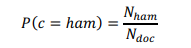

In [29]:
p_ham = n_ham/n_doc
p_ham

0.36159577024753664

### Prior probability for spam

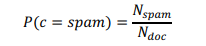

In [30]:
p_spam = n_spam/n_doc
p_spam

0.6384042297524634

## Computing the Likelihood of each word (15 points + 5 points for Laplace smoothing)

### Dictionary containing the number of occurrences of each word in the dataset

Dictionary was used to make checking the frequency of specific words easier.

In [31]:
word_occurences = {}
words = list(train_words_freq.keys())
for word in words:
    word_occurences[word] = feature_matrix_train[word].sum()

word_occurences

{'list': 3961,
 'ago': 661,
 'running': 953,
 'set': 1572,
 'archive': 184,
 'server': 558,
 'official': 188,
 'message': 3618,
 'moment': 189,
 'joe': 150,
 'people': 1785,
 'desire': 245,
 'discussion': 602,
 'assume': 207,
 'will': 11322,
 'provided': 299,
 'operate': 199,
 'going': 1185,
 'limit': 172,
 'sort': 311,
 'net': 226,
 'well': 2405,
 'hope': 841,
 'help': 3805,
 'problem': 2359,
 'resource': 344,
 'policy': 217,
 'subject': 3580,
 'appropriate': 280,
 'call': 1740,
 'simple': 635,
 'follow': 308,
 'teaching': 247,
 'thinking': 273,
 'subscribe': 1499,
 'interest': 595,
 'interesting': 466,
 'setting': 321,
 'language': 519,
 'magazine': 213,
 'days': 1567,
 'material': 332,
 'intend': 227,
 'post': 1138,
 'higher': 391,
 'quality': 526,
 'send': 3685,
 'luxury': 155,
 'buy': 728,
 'frank': 389,
 'muller': 199,
 'omega': 201,
 'tag': 248,
 'full': 1142,
 'gold': 3896,
 'men': 618,
 'fast': 809,
 'delivery': 421,
 'shipping': 635,
 'visit': 677,
 'shop': 207,
 'academic': 

### Dictionary containing the number of occurrences of each word in the ham vocabulary

In [32]:
ham_word_occurences = {}
words = list(train_words_freq.keys())
for word in words:
    word_occurences = feature_matrix_ham[word].sum()
    if word_occurences > 0:
        ham_word_occurences[word] = word_occurences
ham_word_occurences

{'list': 3649,
 'ago': 367,
 'running': 926,
 'set': 1455,
 'archive': 181,
 'server': 465,
 'official': 118,
 'message': 3116,
 'moment': 130,
 'joe': 148,
 'people': 1349,
 'desire': 65,
 'discussion': 601,
 'assume': 192,
 'will': 6520,
 'provided': 242,
 'operate': 101,
 'going': 749,
 'limit': 160,
 'sort': 279,
 'net': 156,
 'well': 1433,
 'hope': 728,
 'help': 3027,
 'problem': 2287,
 'resource': 90,
 'policy': 153,
 'subject': 3505,
 'appropriate': 236,
 'call': 638,
 'simple': 601,
 'follow': 204,
 'teaching': 247,
 'thinking': 256,
 'subscribe': 1475,
 'interest': 268,
 'interesting': 348,
 'setting': 313,
 'language': 456,
 'magazine': 77,
 'days': 341,
 'material': 234,
 'intend': 55,
 'post': 1110,
 'higher': 241,
 'quality': 146,
 'send': 3413,
 'luxury': 13,
 'buy': 366,
 'frank': 241,
 'muller': 3,
 'omega': 5,
 'tag': 32,
 'full': 417,
 'gold': 94,
 'men': 318,
 'fast': 290,
 'delivery': 72,
 'shipping': 76,
 'visit': 149,
 'shop': 43,
 'academic': 175,
 'knowledge': 2

### Dictionary containing the number of occurrences of each word in the spam vocabulary

In [33]:
spam_word_occurences = {}
words = list(train_words_freq.keys())
for word in words:
    word_occurences = feature_matrix_spam[word].sum()
    if word_occurences > 0:
        spam_word_occurences[word] = word_occurences
spam_word_occurences

{'list': 312,
 'ago': 294,
 'running': 27,
 'set': 117,
 'archive': 3,
 'server': 93,
 'official': 70,
 'message': 502,
 'moment': 59,
 'joe': 2,
 'people': 436,
 'desire': 180,
 'discussion': 1,
 'assume': 15,
 'will': 4802,
 'provided': 57,
 'operate': 98,
 'going': 436,
 'limit': 12,
 'sort': 32,
 'net': 70,
 'well': 972,
 'hope': 113,
 'help': 778,
 'problem': 72,
 'resource': 254,
 'policy': 64,
 'subject': 75,
 'appropriate': 44,
 'call': 1102,
 'simple': 34,
 'follow': 104,
 'thinking': 17,
 'subscribe': 24,
 'interest': 327,
 'interesting': 118,
 'setting': 8,
 'language': 63,
 'magazine': 136,
 'days': 1226,
 'material': 98,
 'intend': 172,
 'post': 28,
 'higher': 150,
 'quality': 380,
 'send': 272,
 'luxury': 142,
 'buy': 362,
 'frank': 148,
 'muller': 196,
 'omega': 196,
 'tag': 216,
 'full': 725,
 'gold': 3802,
 'men': 300,
 'fast': 519,
 'delivery': 349,
 'shipping': 559,
 'visit': 528,
 'shop': 164,
 'academic': 87,
 'knowledge': 209,
 'experience': 610,
 'lack': 52,
 'tu

### Functions and values used to compute the likelihood of words

#### Func1: Function to count the number of occurences of a word in a class 

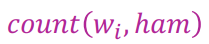

In [34]:
# counts the number of occurence of a word given a class type (i.e., ham or spam)
def count_word_in_class(word, word_occurences_in_class):
    if word in word_occurences_in_class:
        word_count = word_occurences_in_class[word]
        return word_count
    else:
        word_count = 0
        return word_count

# count_word_in_class('font', spam_word_occurences)

#### Func2: Function to count the total number of word occurences in a class

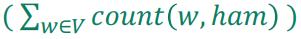

In [35]:
# counts the total number of word occurences in a class type
def total_words_in_class(word_occurences_in_class):
    total = sum(word_occurences_in_class.values())
    return total

# total_words_in_class(spam_word_occurences)

#### Val1: The lambda value

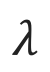

In [36]:
λ = 1

#### Val2: The |V| or total number of unique words

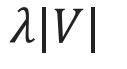

In [37]:
total_unique_words = len(train_words_freq)
total_unique_words

1232

### Computing the likelihood of a word (with Laplace smoothing)

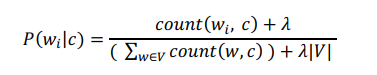

In [38]:
def compute_word_likelihood_in_class(word, word_occurences_in_class, class_type, λ, total_unique_words):
    numerator = count_word_in_class(word, word_occurences_in_class) + λ
    denominator = total_words_in_class(word_occurences_in_class) + (λ*total_unique_words)
    likelihood = numerator/denominator
    return likelihood

# compute_word_likelihood_in_class('font', spam_word_occurences, 'spam', λ, total_unique_words)

## Classifying the emails (10 points + 10 points for computing the log probabilities)

### Formula of the Naive Bayes classifier using log probabilities

#### Function to get the summation of the log probabilities of words in the document given the class

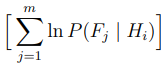

In [39]:
def get_sum_words_logprob(email_words, word_occurences_in_class, class_type, λ, total_unique_words):
    logprobs = []
    for word in email_words:
        word_prob = compute_word_likelihood_in_class(word, word_occurences_in_class, class_type, λ, total_unique_words)
        word_logprob = np.log(word_prob)
        logprobs.append(word_logprob)
    return np.sum(logprobs)
    

#### The Naive Bayes classifier using log probabilities

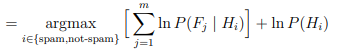

In [40]:
def naive_bayes_classifier(p_ham, p_spam, email_words, ham_word_occurences, spam_word_occurences, λ, total_unique_words):
    class_probs = {'ham': 0, 'spam': 0}
    class_types = list(class_probs.keys())
    
    for class_type in class_types:
        class_prior_logprob = 0
        if class_type == 'ham':
            sum_words_logprob = get_sum_words_logprob(email_words, ham_word_occurences, class_type, λ, total_unique_words)
            class_prior_logprob = np.log(p_ham)
        else:
            sum_words_logprob = get_sum_words_logprob(email_words, spam_word_occurences, class_type, λ, total_unique_words)
            class_prior_logprob = np.log(p_spam)
        
        class_prob = sum_words_logprob + class_prior_logprob
        class_probs[class_type] = class_prob
        
    final_class = max(class_probs, key=class_probs.get)
    
    return final_class

## Testing the Classifier (10 points)

### Using the Naive Bayes on an unknown message (sample)

In [41]:
email_body = 'best offer month time' # this is actually a spam
email_words = email_body.split(" ")
result = naive_bayes_classifier(p_ham, p_spam, email_words, ham_word_occurences, spam_word_occurences, λ, total_unique_words)
print(result)

spam


### Using the Naive Bayes classifier on the testing set

In [42]:
predicted = []
actual = list(test_df['Category'])

emails = list(test_df['Message'])

for email in emails:
    email_words = email.split(" ")
    result = naive_bayes_classifier(p_ham, p_spam, email_words, ham_word_occurences, spam_word_occurences, λ, total_unique_words)
    predicted.append(result)

## Performance Evaluation (10 points)

### Confusion matrix (when only words that have frequency of 150 or more is used)

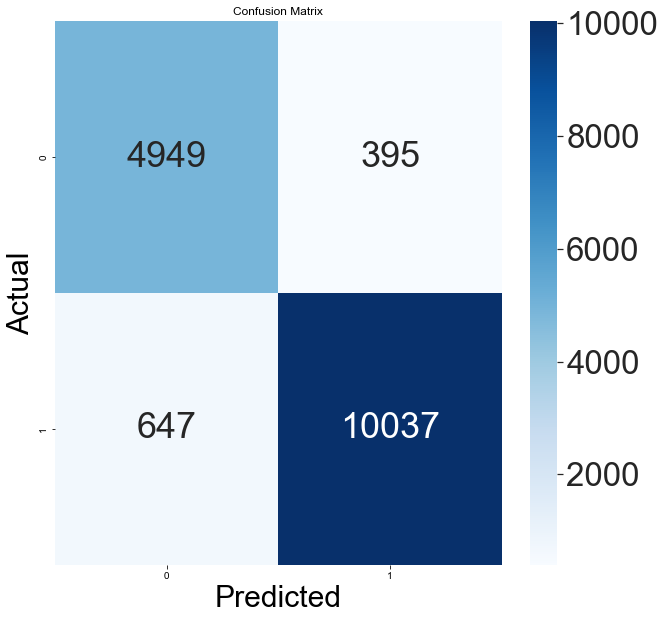

In [43]:
cm = confusion_matrix(actual, predicted)
plt.figure(figsize=(10, 10))
plt.title("Confusion Matrix")
sns.set(font_scale=3.0)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
label_font = {'size':'30'}
plt.xlabel('Predicted', fontdict=label_font)
plt.ylabel('Actual', fontdict=label_font)
plt.show()

### Classification report in terms of accuracy, recall, and precision (when only words that have frequency of 150 or more is used)

In [44]:
# Accuracy, recall, precision, f1_score
accuracy = accuracy_score(actual, predicted)
recall = recall_score(actual, predicted, average="binary", pos_label="spam")
precision = precision_score(actual, predicted, average="binary", pos_label="spam")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall* 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")

Accuracy: 93.50%
Recall: 93.94%
Precision: 96.21%
